In [1]:
import pandas as pd
import csv
import numpy as np
import pdb
import os
from matplotlib import pyplot as plt
import matplotlib
import pdb
import jax_cosmo as jc
import tomo_challenge as tc
import scipy.integrate as integrate
from scipy.ndimage import gaussian_filter1d

Found classifier funbins
Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
#global settings
bin_num = 12
is_buzzard = True #am I using buzzard or DC2
is_unrep = True
keep_frac = 0.9
#optimizer settings
if is_buzzard:
    z_max=2.3 #maximum (true) redshift in the sample, used for computing N(z)
if not is_buzzard:
    z_max = 3.03
    

spacing = 1000 #number of z points in grid
#delta_z = z_max/spacing

#file locations
if is_buzzard:
    data_set = 'Buzzard'
if not is_buzzard:
    data_set = 'DC2'

folder = 'nn_class/unrep'

#misclass trainings
misclass_equal_num_folder = 'misclass_nnc_equal_num'
misclass_optimal_folder = 'misclass_nnc_optimal'


In [3]:
def load_data(filepath, num_of_bins, use_size, use_misclass):
    
    '''
    This function uses the inputs to determine which files to load in and how to arrange the dataframe of features
    Inputs:
    data_set: a string indicating which data set to use. this is either 'Buzzard' or 'DC2'
    use_size: boolean, was the NNC trained using size data or not
    use_misclass: boolean, was the NNC trained to identify misclassified galaxies
    '''

    if use_misclass:
        if use_size:
            size_string = 'size'
        if not use_size:
            size_string = 'no_string'
        
        features_dict = {}
        for i in range(bin_num):
        
            features = pd.read_csv(f'{filepath}/tpzrun.nn_app_bin_{i}',delimiter=' ', header=0)
            
                              
            #arranging the dataframe correctly
        
            confidences = pd.read_csv(f'{filepath}/nnc_epoch1000_{i}/results_application.dat', header=None)
            features[f'conf'] = confidences
             
            features_dict[f'bin_{i}'] = features
         
        
        dataframe_list = []
        for i in range(bin_num):
            dataframe_list.append(features_dict[f'bin_{i}'])
         
        
        features = pd.concat(dataframe_list, ignore_index=True)
    
    if not use_misclass:
        features = pd.read_csv(f'{filepath}/tpzrun.nn_app', delimiter=' ', header=0)
    
        outlier_confidences = pd.read_csv(f'{filepath}/nnc_epoch1000/results_application.dat', header=None)
                          
        #arranging the dataframe correctly
        features['conf'] = outlier_confidences
        if use_size:
            features['specz'] = features['size']
            features['size'] = features['g']
        else:
            features['specz'] = features['g']
        features['g'] = features['r']
        features['r'] = features['i']
        features['i'] = features['z']
        features['z'] = features['y']
        features['y'] = features['gr']
        features['gr'] = features['ri']
        features['ri'] = features['iz']
        features['iz'] = features['zy']
        features['zy'] = features['gri']
        features['gri'] = features['riz']
        features['riz'] = features['izy']
        features['izy'] = features['zphot']
        features['zphot'] = features['zconf']
        features['zconf'] = features['zerr']
        features['zerr'] = features['eg']
        features['eg'] = features['er']
        features['er'] = features['ei']
        features['ei'] = features['ez']
        features['ez'] = features['ey']
        features['ey'] = features['egr']
        features['egr'] = features['eri']
        features['eri'] = features['eiz']
        features['eiz'] = features['ezy']
        features['ezy'] = features['egri']
        features['egri'] = features['eriz']
        features['eriz'] = features['eizy']
        if use_size:
            features['eizy'] = features['Unnamed: 29']
        else: 
            features['eizy'] = features['Unnamed: 28']
    
    return features



In [4]:
def bin_edges(bin_method, bin_num, z_list):
    '''
    This function finds the bin egdes for a given method of binning
    
    input paramters are:
    bin_method: can be 'equal_chi', 'equal_z' or 'equal_num
    bin_num: the number of bins required
    z_list: the set of photo-z being used 
    
    returns an array of bin edges
    '''
    if bin_method == 'equal_chi': #funbins bin egdes by equal chi
        zgrid = np.linspace(0, z_list.max(), 1000)
        agrid = 1 / (1 + zgrid)
        model = jc.parameters.Planck15()
        chi_grid = jc.background.radial_comoving_distance(model, agrid)
        # Compute bin edges that are equally spaced in chi.
        chi_edges = np.linspace(0, chi_grid[-1], bin_num + 1)
        bin_edges = np.empty(bin_num + 1)
        bin_edges[0] = 0.
        bin_edges[-1] = z_list.max()
        bin_edges[1:-1] = np.interp(chi_edges[1:-1], chi_grid, zgrid)
        
    if bin_method == 'equal_z':
        bin_edges = np.linspace(0, z_list.max(), bin_num+1)
        
    if bin_method == 'equal_num':
        
        total_num = len(z_list)
        new_z_list = sorted(z_list)

        objects_per_bin = int(total_num / bin_num)

        #set bin edges
        #bin_edges = np.empty(bin_num+1)
        #bin_edges[0] = 0.
        #bin_edges[-1] = z_list.max()
        bin_edges = [0.]
        k = 1
        while k < bin_num:
            bin_edges.append(new_z_list[k*objects_per_bin])
            k+=1
        bin_edges.append(z_list.max())
        bin_edges = np.asarray(bin_edges)
            
    return bin_edges

def do_binning(z_values, bin_edge_list):
    '''
    This function sorts galaxies into a given set of bin edges
    
    input parameters are:
    z_values: the list of photo-zs to sort
    bin_edge_list: an array or list of bin edges (first entry must be 0, last entry must be the maximum photo-z)
    num_of_bins: number of bins
    
    outputs an array of the bin each object was sorted into. Bins range from 0. to num_of_bins-1
    '''
    results = np.searchsorted(bin_edge_list, z_values)
    #for k in range(len(z_values)):
    #    for j in range(0, num_of_bins):
    #        if (z_values[k] > bin_edge_list[j]) and (z_values[k] <= bin_edge_list[j+1]):
    #            results.append(j)
    results_arr = np.array(results-1)
        
    return results_arr

def get_scores(results, specz_list, which_sample, sample_size, metric_list):
    '''
    Uses tomo challenge machinery to compute SNR and/or FOM for a given set of galaxies and bins.
    
    input parameters:
    results: a list of the bin each objects was sorted into
    specz_list: the true redshifts of each object
    which_sample: True or False based on whether using buzzard or DC2. If using Buzzard, which_sample=True. If using DC2, which_sample=False.
    sample_size: this is the total sample size before any cuts have been implemented
    metric_list: a list of metrics you want computed. List can include "SNR_3x2", "SNR_gg", "SNR_ww", 'FOM_3x2', 'FOM_gg', 'FOM_ww'
    
    returns a dictionary of each requested metric and the computed score in the form {'metric name': value}
    also prints out score in case jupyter crashes while computing
    '''
    score = tc.compute_scores(results, specz_list, which_sample, sample_size, metric_list)
    
    print(score)
    
    return score

In [5]:
def make_bins(data_features, number_of_bins, name_string):
    '''
    This function creates the actual bins for plotting in the histograms
    '''
    
    #first, make a dictionary. This will be converted to a dataframe at the end
    test_dict = {}
    test_dict['features'] = data_features
    for i in range(number_of_bins):
        bin_name = f'bin_{i}_{name_string}'
        if bin_name not in test_dict:
            test_dict[bin_name] = data_features[data_features[f'{name_string}']==i]
            
    
    return test_dict


In [6]:
def dchi_dz(z_max, spacing):
    '''
    This function computes dchi_dz at every point in the redshift grid. 
    Redshift grid goes from 0 to the maximum redshift in the sample.
    '''
    zgrid = np.linspace(0, z_max, int(spacing))
    agrid = 1/(1+zgrid)
    model = jc.parameters.Planck15() #defines the cosmology, same as funbins
    chi_grid = jc.background.radial_comoving_distance(model, agrid)
    chi_grid = chi_grid *model.h


    dchi_dz_list = []
    for i in range(len(zgrid)-1):
        delta_chi = chi_grid[i+1]-chi_grid[i]
        dchi_dz_list.append(float(delta_chi)/float(delta_z))
    return zgrid, dchi_dz_list

def dN_dz(z_list, spacing, delta_z):
    '''
    This function calculates N(z) at every point in the redshift grid.
    '''
    N_of_z_list, bins, _ = plt.hist(z_list, spacing)
    dN_dz_list = N_of_z_list/delta_z    
    return dN_dz_list

def bin_optimizer(z_grid, z_max, dN_dz_dist, dchi_dz_dist, alpha, beta, delta_z_step, num_of_bins):
    
    '''
    Finds the bin egdes for a given interpolation between equal chi and equal number binning.
    z_grid: defines the redshift grid, goes from 0 to the maximum redshift of the sample
    z_max: maximum redshift of the sample
    dN_dz_list: N(z) at every point in z_grid
    dchi_dz_dist: dchi/dz at every point in z_grid
    alpha: alpha of 0 corresponds to equal chi binning, alpha of 1 corresponds to equal number binning
    delta_z_step: distance between redshifts in z_grid
    num_of_bins: number of bins to produce
    Finds M for a given configuration, divides M into num_of_bins bins. Then calculates M for every value in z_grid.
    Interpolates between the bin edges in M space and bin edges in z space
    '''
    
    #start by finding total M
    to_integrate = []
    #alpha = 1.0
    for i in range(len(dchi_dz_dist)-1):
        if dN_dz_dist[i] == 0:
            to_integrate.append(0)
        else:
            to_integrate.append((dN_dz_dist[i]**alpha)*(dchi_dz_dist[i]**(beta)))
    M = integrate.trapezoid(to_integrate, dx=delta_z_step)
    
    #Now we have M, can divide into the correct number of bins
    M_edges = []
    for i in range(num_of_bins):
        M_edges.append(i*(M/num_of_bins))
        
    M_edges.append(M)
    
    #Interpolate between M and z to get bin edges in z
    M_of_z = []

    for i in range(len(z_grid)):
        dN_dz_temp = dN_dz_dist[0:i]#cuts dN_dz off at the relevant value of z
        dchi_dz_temp = dchi_dz_dist[0:i]
        integrand_temp = []
        for j in range(len(dchi_dz_temp)-1):
            if dN_dz_temp[j] == 0:
                integrand_temp.append(0)
            else:
                integrand_temp.append((dN_dz_temp[j]**alpha)*(dchi_dz_temp[j]**(beta)))
        M_of_z_val = integrate.trapezoid(integrand_temp, dx=delta_z_step)#integrating only to each value of z
        M_of_z.append(M_of_z_val)
    z_edges = np.empty(num_of_bins + 1)
    z_edges[0] = 0.0
    z_edges[-1] = z_max
    z_edges[1:-1] = np.interp(M_edges[1:-1], M_of_z, z_grid)
    
    return M, M_of_z, M_edges, z_edges


def M_of_z_binning(z_list, z_grid, M_grid, M_edges, num_of_bins):
    M_list = []
    for i in range(len(z_list)):
        M_list.append(np.interp(z_list[i], z_grid, M_grid))
        
    results_arr = do_binning(M_list, M_edges, num_of_bins)
    return results_arr
                    
        

# Step 1: Determine Optimal Binning Scheme

### Load features
From features, obtain photo-z and true z, calculate NMAD and $\frac{dN}{dz}$

/global/u2/i/irenem/mydesc/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


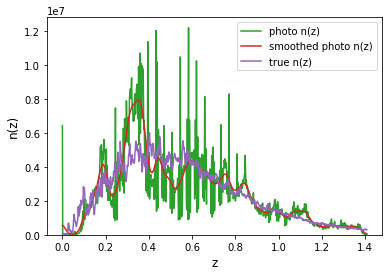

In [7]:
#load features

file_path = f'{folder}/{data_set}'
features = load_data(file_path, num_of_bins=bin_num, use_size=True, use_misclass=False)

z_phot = features['zphot'].to_numpy()
z_spec = features['specz'].to_numpy()

#calculate NMAD
phot_z_err = (z_phot-z_spec)/(1+z_spec)

median_err = np.median(phot_z_err)

deviations  = np.absolute(phot_z_err - median_err)
mad = np.median(deviations)
nmad = 1.4826*mad

#Calculate dN/dz distributions
z_max = np.max(z_phot)
spacing=1000
delta_z = z_max/spacing
z_grid, dchi_dz_grid = dchi_dz(z_max, spacing)

#for the true n(z), we need to exclude redshifts above the maximum photo-z estimate 
z_spec_cutoff = features[features['specz'] <= z_max]['specz'].to_numpy()

dN_dz_true = dN_dz(z_spec_cutoff, spacing, delta_z)
dN_dz_phot = dN_dz(z_phot, spacing, delta_z)
dN_dz_smoothed = gaussian_filter1d(dN_dz_phot, 10)
z_grid_fit = np.linspace(0, z_max, spacing)


plt.plot(z_grid_fit, dN_dz_phot, label='photo n(z)')
plt.plot(z_grid_fit, dN_dz_smoothed, label='smoothed photo n(z)')
plt.plot(z_grid_fit, dN_dz_true, label='true n(z)', )

plt.xlabel('z', fontsize=12)
plt.ylabel('n(z)', fontsize=12)

plt.legend()
plt.savefig('paper_plots/n(z)_comp_buzzard.png', bbox_inches='tight')
plt.show()

In [8]:
plt.close()

### Calculate SNR for different $\alpha$, $\beta$ combinations

SNR results collected into arrays so they don't need to be recalculated

In [9]:
#produces grid where rows are constant alpha!

alpha_list = [-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
beta_list = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0] 


In [10]:
#Buzzard smoothed (sigma=10)
snr_grid_smoothed = np.zeros((len(alpha_list), len(beta_list)))

snr_grid_smoothed[0] = [1063.40775166, 1041.31246824, 1068.66382184, 1071.21161846, 1092.44485546, 1106.18201819, 1110.07448173, 1119.4467167, 1115.52941317, 1122.56008379, 1146.6803898, 1115.16050262, 1118.6810963, 1153.42882497, 1121.29911412, 1095.81047076, 1116.64019006]
snr_grid_smoothed[1] = [1119.01214772, 1136.91708448, 1166.31001602, 1196.28747595, 1187.08831869, 1202.39121222, 1239.82881807, 1249.91253774, 1217.81064187, 1229.87961032, 1258.99731385, 1257.00420187, 1247.1730978,  1253.37896105, 1246.11143705, 1246.31909024, 1239.19693648]
snr_grid_smoothed[2] = [1204.92412734, 1222.26134898, 1250.27921535, 1272.54374536, 1285.89617081, 1287.37783963, 1287.28316561, 1292.29677693, 1309.17141931, 1318.77235178, 1333.96265853, 1332.07555972, 1330.95881758, 1329.883832, 1330.15789915, 1322.20010376, 1321.73856963]
snr_grid_smoothed[3] = [1277.05814028, 1294.53582167, 1307.00856307, 1312.2053172, 1326.03388794, 1343.73433309, 1360.01097151, 1362.26461788, 1358.99715557, 1358.79008127, 1362.1018828, 1365.00608814, 1363.29912825, 1355.72038713, 1358.34528559, 1362.19266226, 1364.2964745]
snr_grid_smoothed[4] = [1332.99062167, 1340.53570431, 1347.5248807165312, 1351.0198154047225, 1356.0267762137817, 1363.1233365525727, 1375.5714134313866, 1382.653585790944, 1383.0687188218906, 1383.82343593587, 1386.0885806868305, 1383.4185273632756, 1381.536251622814, 1385.4858643495504, 1386.2776234570508, 1380.39832934, 1370.89532837]
snr_grid_smoothed[5] = [1367.03953292, 1362.12650533, 1365.54983735, 1372.46439042, 1377.55917951, 1379.01894578, 1377.33271027, 1384.9197892, 1392.5054273, 1392.33426069, 1389.83774984, 1382.31682448, 1380.96906332, 1385.81189227, 1382.71893533, 1375.71985095, 1366.01188667]
snr_grid_smoothed[6] = [1378.92525482, 1386.84440641, 1383.06918639, 1376.64274203, 1372.41033668, 1373.98144921, 1382.1476865, 1386.03019163, 1387.97095067, 1381.98124508, 1378.55690621, 1381.07057695, 1380.55881088, 1371.42319767, 1367.73968045, 1360.12029799, 1358.22934803]
snr_grid_smoothed[7] = [1383.90062628, 1381.14538863, 1376.72381894, 1376.47799864, 1381.44174402, 1377.20026461, 1372.51633888, 1365.59107976, 1365.98118705, 1368.73778474, 1371.26330586, 1365.07545412, 1364.91927961, 1356.58102458, 1352.59461381, 1351.81728091, 1353.4631035 ]
snr_grid_smoothed[8] = [1376.55648337, 1380.66691002, 1377.4576424625752, 1373.130748386917, 1366.2380248433815, 1358.3099879285803, 1355.069106153197, 1355.3504932207788, 1351.3223538961038, 1351.2368208546604, 1348.774989505978, 1343.2504563115192, 1339.2845711650073, 1339.7764104179205, 1342.5308906450884, 1337.3220358590277, 1332.63431713]
snr_grid_smoothed[9] = [1365.90099164, 1362.90852153, 1357.5495180511327, 1353.0977559199148, 1350.937694700461, 1350.8311768893711, 1343.4376768948791, 1342.4593040633993, 1336.4720907037442, 1329.3896661191707, 1326.072825417361, 1323.355834814866, 1322.42311752, 1317.54124132, 1314.81539673, 1310.81734499, 1303.48713944]
snr_grid_smoothed[10] = [1338.73485481, 1337.83199532, 1341.3180244853866, 1338.980533863582, 1340.1334369535152, 1333.9610969709156, 1326.6031290168328, 1319.4293147807675, 1316.2975943447473, 1316.4793917347417, 1309.1997167284621, 1305.4414161681043, 1299.6673990768477, 1291.0232503657803, 1283.9075526584902, 1279.15255576, 1276.72906646] 

for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        alpha_coord = int((alpha_list[i]+0.5)/0.25)
        beta_coord = int((beta_list[j]+1.0)/0.25)
        
        if snr_grid_smoothed[alpha_coord][beta_coord] > 0.001:
            print('SNR already computed: ', snr_grid_smoothed[alpha_coord][beta_coord])
        else:
            print('alpha: ',alpha_list[i], ', beta: ', beta_list[j])
            M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_smoothed, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
            results_arr = do_binning(z_phot, z_edges_i, bin_num)
            scores = get_scores(results_arr, z_spec, is_buzzard, len(z_phot), ['SNR_3x2'])
            snr_grid_smoothed[alpha_coord][beta_coord] = scores['SNR_3x2']
    print(snr_grid_smoothed[i])

SNR already computed:  1063.40775166
SNR already computed:  1041.31246824
SNR already computed:  1068.66382184
SNR already computed:  1071.21161846
SNR already computed:  1092.44485546
SNR already computed:  1106.18201819
SNR already computed:  1110.07448173
SNR already computed:  1119.4467167
SNR already computed:  1115.52941317
SNR already computed:  1122.56008379
SNR already computed:  1146.6803898
SNR already computed:  1115.16050262
SNR already computed:  1118.6810963
SNR already computed:  1153.42882497
SNR already computed:  1121.29911412
SNR already computed:  1095.81047076
SNR already computed:  1116.64019006
[1063.40775166 1041.31246824 1068.66382184 1071.21161846 1092.44485546
 1106.18201819 1110.07448173 1119.4467167  1115.52941317 1122.56008379
 1146.6803898  1115.16050262 1118.6810963  1153.42882497 1121.29911412
 1095.81047076 1116.64019006]
SNR already computed:  1119.01214772
SNR already computed:  1136.91708448
SNR already computed:  1166.31001602
SNR already computed

In [11]:
#cosmoDC2 true n(z) unsmoothed
snr_grid_true = np.zeros((len(alpha_list), len(beta_list)))

snr_grid_true[0] = [1043.08809432, 1043.08809432, 1043.08809432, 1074.15645112, 1082.68434424, 1100.04246192, 1088.3243265, 1109.53878549, 1108.45972703, 1126.26453103, 1107.68405853, 1102.90215079, 1132.80829695, 1104.00036726, 1085.82755457, 1106.23420213, 1103.25616142]
snr_grid_true[1] = [1163.3422966254823, 1163.3422966254823, 1163.3422966254823, 1197.48704790673, 1193.6973026129167, 1198.026284455772, 1239.9299274933867, 1256.8210651541906, 1231.4738484619756, 1230.5712347538733, 1256.9280750724351, 1257.96639967, 1255.92445285, 1259.33282322, 1246.50229161, 1249.21865939, 1243.3238553]
snr_grid_true[2] = [1250.27921535, 1250.27921535, 1250.27921535, 1272.54374536, 1285.89617081, 1287.37783963, 1287.28316561, 1292.29677693, 1309.17141931, 1318.77235178, 1333.96265853, 1332.07555972, 1330.95881758, 1329.883832, 1330.15789915, 1322.20010376, 1321.73856963]
snr_grid_true[3] = [1306.12217375, 1306.12217375, 1306.12217375, 1314.96583901, 1332.42534752, 1347.27210598, 1359.2672088, 1358.03475658, 1352.6067038,  1353.09803938, 1357.3955104, 1362.40389996, 1359.66826959, 1357.42285335, 1363.23644644, 1368.81354163, 1369.1365788 ]
snr_grid_true[4] = [1350.1381623703137, 1350.1381623703137, 1350.1381623703137, 1357.7228101704122, 1357.481031939172, 1370.1518171291077, 1383.589494751238, 1391.3425287618622, 1385.6436031905016, 1389.1813878024336, 1391.47390029, 1389.46497811, 1390.22391538, 1384.68578528, 1380.9317183,  1380.16572612, 1372.4060969]
snr_grid_true[5] = [1369.89386311, 1369.89386311, 1369.89386311, 1379.83363121, 1390.5876486,  1396.28563005, 1395.31307729, 1398.58702371, 1400.5985042, 1406.08314798, 1410.1472695, 1404.00958136, 1400.50297738, 1400.62278556, 1397.28990398, 1392.70748314, 1385.36464961]
snr_grid_true[6] = [1396.19378387, 1396.19378387, 1396.19378387, 1397.82856805, 1399.50032618, 1402.8712109,  1405.88743006, 1410.90669421, 1412.89856195, 1410.92618269, 1407.29763285, 1405.0472122, 1398.01619135, 1399.82789248, 1401.99501685, 1400.02381624, 1395.18504116]
snr_grid_true[7] = [1406.83329839, 1406.83329839, 1406.83329839, 1410.86805172, 1412.04592189, 1410.65120344, 1404.78600055, 1408.90006305, 1409.19861059, 1409.77931805, 1407.34485587, 1404.3469505, 1398.9360626, 1397.3267577, 1396.69855964, 1397.43620529, 1397.86398269]
snr_grid_true[8] = [1412.9580515161076, 1413.8357615000746, 1415.49789297, 1412.67543122, 1412.74316899, 1405.89372358, 1402.14413526, 1401.40079176, 1403.77750247, 1406.42309108, 1407.14848366, 1403.59096796, 1397.37485576, 1393.59127271, 1393.25932616, 1393.89989821, 1393.24302589]
snr_grid_true[9] = [1413.4451246461917, 1413.4451246461917, 1413.4451246461917, 1409.9578372723138, 1405.1058637186509, 1401.406524361532, 1400.6247214815346, 1403.751826882816, 1403.3725153059938, 1404.9145539817916, 1402.285653347527, 1396.4092515701195, 1390.342975906217, 1389.5909306987376, 1386.2170746714312, 1383.9892176727362, 1384.218796795709]
snr_grid_true[10] =  [1407.36319173, 1407.36319173, 1407.36319173, 1403.09804504, 1403.68070517, 1401.12262512, 1400.0726026, 1400.38080802, 1398.80494511, 1395.58102465, 1393.32251148, 1394.58682444, 1388.21734443, 1382.38081676, 1377.40020804, 1376.50485302, 1373.36082837]


for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        alpha_coord = int((alpha_list[i]+0.5)/0.25)
        beta_coord = int((beta_list[j]+1.0)/0.25)
        
        if snr_grid_true[alpha_coord][beta_coord] > 0.001:
            print('SNR already computed: ', snr_grid_true[alpha_coord][beta_coord])
        else:
            print('alpha: ',alpha_list[i], ', beta: ', beta_list[j])
            M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
            results_arr = do_binning(z_phot, z_edges_i, bin_num)
            scores = get_scores(results_arr, z_spec, is_buzzard, len(z_phot), ['SNR_3x2'])
            snr_grid_true[alpha_coord][beta_coord] = scores['SNR_3x2']
    print(snr_grid_true[i])

SNR already computed:  1043.08809432
SNR already computed:  1043.08809432
SNR already computed:  1043.08809432
SNR already computed:  1074.15645112
SNR already computed:  1082.68434424
SNR already computed:  1100.04246192
SNR already computed:  1088.3243265
SNR already computed:  1109.53878549
SNR already computed:  1108.45972703
SNR already computed:  1126.26453103
SNR already computed:  1107.68405853
SNR already computed:  1102.90215079
SNR already computed:  1132.80829695
SNR already computed:  1104.00036726
SNR already computed:  1085.82755457
SNR already computed:  1106.23420213
SNR already computed:  1103.25616142
[1043.08809432 1043.08809432 1043.08809432 1074.15645112 1082.68434424
 1100.04246192 1088.3243265  1109.53878549 1108.45972703 1126.26453103
 1107.68405853 1102.90215079 1132.80829695 1104.00036726 1085.82755457
 1106.23420213 1103.25616142]
SNR already computed:  1163.3422966254823
SNR already computed:  1163.3422966254823
SNR already computed:  1163.3422966254823
SNR

### Check if any bins are too narrow
Narrow bins are defined as narrow than the NMAD

In [16]:
alpha_too_narrow = []
beta_too_narrow = []
for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
        narrow = 0
        for k in range(len(z_edges_i)-1):
            if (z_edges_i[k+1] - z_edges_i[k]) < nmad:
                narrow +=1
        if narrow != 0:
            alpha_too_narrow.append(alpha_list[i])
            beta_too_narrow.append(beta_list[j])

print(alpha_too_narrow)
print(beta_too_narrow)

[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.25]
[-0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.0]


### Plot the SNRs 

Line Plots

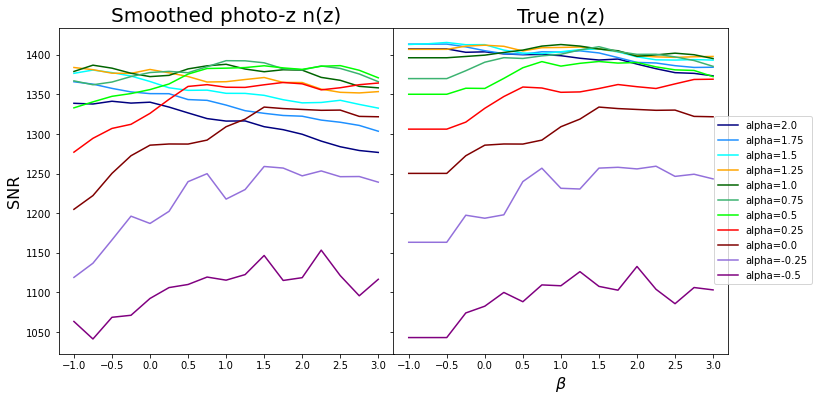

In [18]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 6))
colors_list = ['navy', 'dodgerblue', 'cyan', 'orange', 'darkgreen', 'mediumseagreen', 'lime', 'red', 'maroon', 'mediumpurple', 'purple', 'saddlebrown', 'pink', 'gold', 'deeppink']
for i in range(len(alpha_list)):
    k = len(alpha_list)-i-1
    ax[0].plot(beta_list, snr_grid_smoothed[k], label=f'alpha={alpha_list[k]}', c=colors_list[i])
    ax[1].plot(beta_list, snr_grid_true[k], label=f'alpha={alpha_list[k]}', c=colors_list[i])

ax[0].set_ylabel('SNR', fontsize=16) 
ax[1].set_xlabel(r'$\beta$', fontsize=16)

ax[0].set_title('Smoothed photo-z n(z)', fontsize=20)
ax[1].set_title('True n(z)', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=10)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.show()

In [24]:
x_max_smoothed = np.where((snr_grid_smoothed <= np.max(snr_grid_smoothed)+0.5) & (snr_grid_smoothed >= np.max(snr_grid_smoothed)-0.5))
x_max_smoothed

(array([5, 5]), array([8, 9]))

Grid Plots

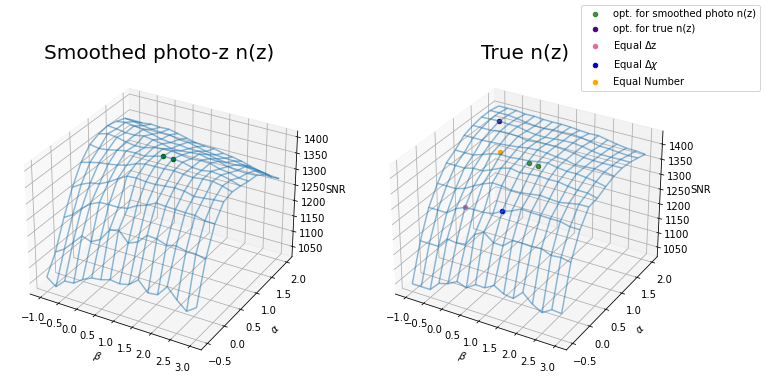

In [12]:
X = np.zeros((len(alpha_list), len(beta_list)))
for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        X[i][j] = alpha_list[i]

Y = np.zeros((len(alpha_list), len(beta_list)))

for i in range(len(alpha_list)):
    Y[i] = beta_list

    
from mpl_toolkits.mplot3d import Axes3D

#x_max = [1.5, 1.75, 2.0, 1.75]
#y_max = [1.25, 0.0, 0.0, 1.5]
#snr_max = [1947.51236391, 1947.57683568, 1947.16749915, 1946.68743119]

max_smoothed = np.where((snr_grid_smoothed <= np.max(snr_grid_smoothed)+0.5) & (snr_grid_smoothed >= np.max(snr_grid_smoothed)-0.5))
max_true = np.where((snr_grid_true <= np.max(snr_grid_true)+0.5) & (snr_grid_true >= np.max(snr_grid_true)-0.5))

x_max_smoothed = []
y_max_smoothed = []
snr_max_smoothed = []
for i in range(len(max_smoothed[0])):
    x_max_smoothed.append(alpha_list[max_smoothed[0][i]])
    y_max_smoothed.append(beta_list[max_smoothed[1][i]])
    snr_max_smoothed.append(snr_grid_smoothed[max_smoothed[0][i]][max_smoothed[1][i]])
                            
x_max_true = []
y_max_true = []
snr_max_true = []
for i in range(len(max_true[0])):
    x_max_true.append(alpha_list[max_true[0][i]])
    y_max_true.append(beta_list[max_true[1][i]])
    snr_max_true.append(snr_grid_true[max_true[0][i]][max_true[1][i]])

#x_max_smoothed = [1.25, 1.25]
#y_max_smoothed = [0.75, 1.0]
#snr_max_smoothed = [1943.00627757, 1943.7119175]

#x_max_true = [1.75, 2.0, 2.0, 2.25]
#y_max_true = [1.5, 1.5, 1.75, 2.0]
#snr_max_true = [1959.80625951, 1959.34140312, 1959.96858777, 1960.7879874155085]

prev_binning_x = [0.0, 0.0, 1.0]
prev_binning_y = [0.0, 1.0, 0.0]
prev_binning_snr = []
for i in range(len(prev_binning_x)):
    alpha_coord = int((prev_binning_x[i]+0.5)/0.25)
    beta_coord = int((prev_binning_y[i]+1.0)/0.25)
    
    prev_binning_snr.append(snr_grid_smoothed[alpha_coord][beta_coord])
#prev_binning_snr = [1559.6666230172846, 1704.0045053109795, 1884.35955498]
prev_binning_colors = ['palevioletred', 'mediumblue', 'orange']
binning_names = [r'Equal $\Delta$z', r'Equal $\Delta \chi$', r'Equal Number']

fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
#ax3 = fig.add_subplot(133, projection='3d')


ax1.plot_wireframe(Y, X, snr_grid_smoothed, alpha=0.5)
ax2.plot_wireframe(Y, X, snr_grid_true, alpha=0.5)
#ax3.plot_wireframe(Y2, X2, snr_grid_true, alpha=0.5)

#ax1.scatter(y_max, x_max, snr_max, c='r', depthshade=False)
ax1.scatter(y_max_smoothed, x_max_smoothed, snr_max_smoothed, c='darkgreen', depthshade=False)
#ax3.scatter(y_max, x_max, snr_max, c='r', depthshade=False, label='opt. for photo n(z)', alpha=0.7)
ax2.scatter(y_max_smoothed, x_max_smoothed, snr_max_smoothed, c='darkgreen', depthshade=False, label='opt. for smoothed photo n(z)', alpha=0.7)
ax2.scatter(y_max_true, x_max_true, snr_max_true, c='indigo', depthshade=False, label='opt. for true n(z)')

for i in range(len(prev_binning_x)):
    ax2.scatter(prev_binning_y[i], prev_binning_x[i], prev_binning_snr[i], c=prev_binning_colors[i], depthshade=False, label=binning_names[i])

ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r'$\alpha$')
ax1.set_zlabel('SNR')

ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'$\alpha$')
ax2.set_zlabel('SNR')

#ax3.set_xlabel(r'$\beta$')
#ax3.set_ylabel(r'$\alpha$')
#ax3.set_zlabel('SNR')

#ax1.set_title('Photo-z n(z)', fontsize=20)
ax1.set_title('Smoothed photo-z n(z)', fontsize=20)
ax2.set_title('True n(z)', fontsize=20)

ax1.set_rasterized(True)
ax2.set_rasterized(True)
#ax3.set_rasterized(True)

fig.legend()
#fig.savefig('paper_plots/alpha_beta_comp_cosmodc2.png', bbox_inches='tight')
fig.show()

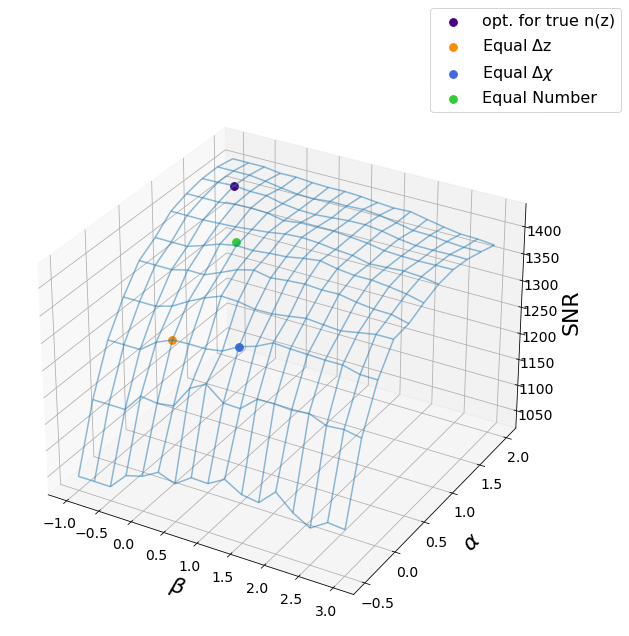

In [13]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#x_max_true = [1.75, 2.0, 2.0, 2.25]
#y_max_true = [1.5, 1.5, 1.75, 2.0]
#snr_max_true = [1959.80625951, 1959.34140312, 1959.96858777, 1960.7879874155085]
#
#prev_binning_x = [0.0, 0.0, 1.0]
#prev_binning_y = [0.0, 1.0, 0.0]
#prev_binning_snr = [1563.419, 1709.155, 1899.652]

prev_binning_colors = ['darkorange', 'royalblue', 'limegreen']
binning_names = [r'Equal $\Delta$z', r'Equal $\Delta \chi$', r'Equal Number']

ax.plot_wireframe(Y, X, snr_grid_true, alpha=0.5)
ax.scatter(y_max_true, x_max_true, snr_max_true, c='indigo', depthshade=False, label='opt. for true n(z)', s=60)
for i in range(len(prev_binning_x)):
    ax.scatter(prev_binning_y[i], prev_binning_x[i], prev_binning_snr[i], c=prev_binning_colors[i], depthshade=False, label=binning_names[i], s=60)
    
ax.set_xlabel(r'$\beta$', fontsize=22)
ax.set_ylabel(r'$\alpha$', fontsize=22)
ax.set_zlabel('SNR', fontsize=22, rotation=90, linespacing=10) 
ax.zaxis.labelpad=10
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10

fig.legend(fontsize=16)
fig.savefig('paper_plots/alpha_beta_grid_buzzard.pdf', bbox_inches='tight')
fig.show()

In [14]:
np.max(snr_grid_true)

1415.49789297

### Compare Binning Choices

In [10]:
#Lets compare equal number, equal chi, equal z and the best case.

alpha = [0.0, 0.0, 1.0, 1.5]
beta = [0.0, 1.0, 0.0, -0.5]
snr = [1285.89617081, 1309.17141931, 1372.41033668, 1415.49789297]

dict_of_dicts = {}
for i in range(len(alpha)):
    M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha[i], beta=beta[i], delta_z_step=delta_z, num_of_bins=bin_num)
    results_arr = do_binning(z_phot, z_edges_i)
    features['bins_num'] = results_arr
    dict_of_dicts[f'alpha_{alpha[i]}_beta_{beta[i]}'] = make_bins(features, number_of_bins=bin_num, name_string = 'bins_num')
    

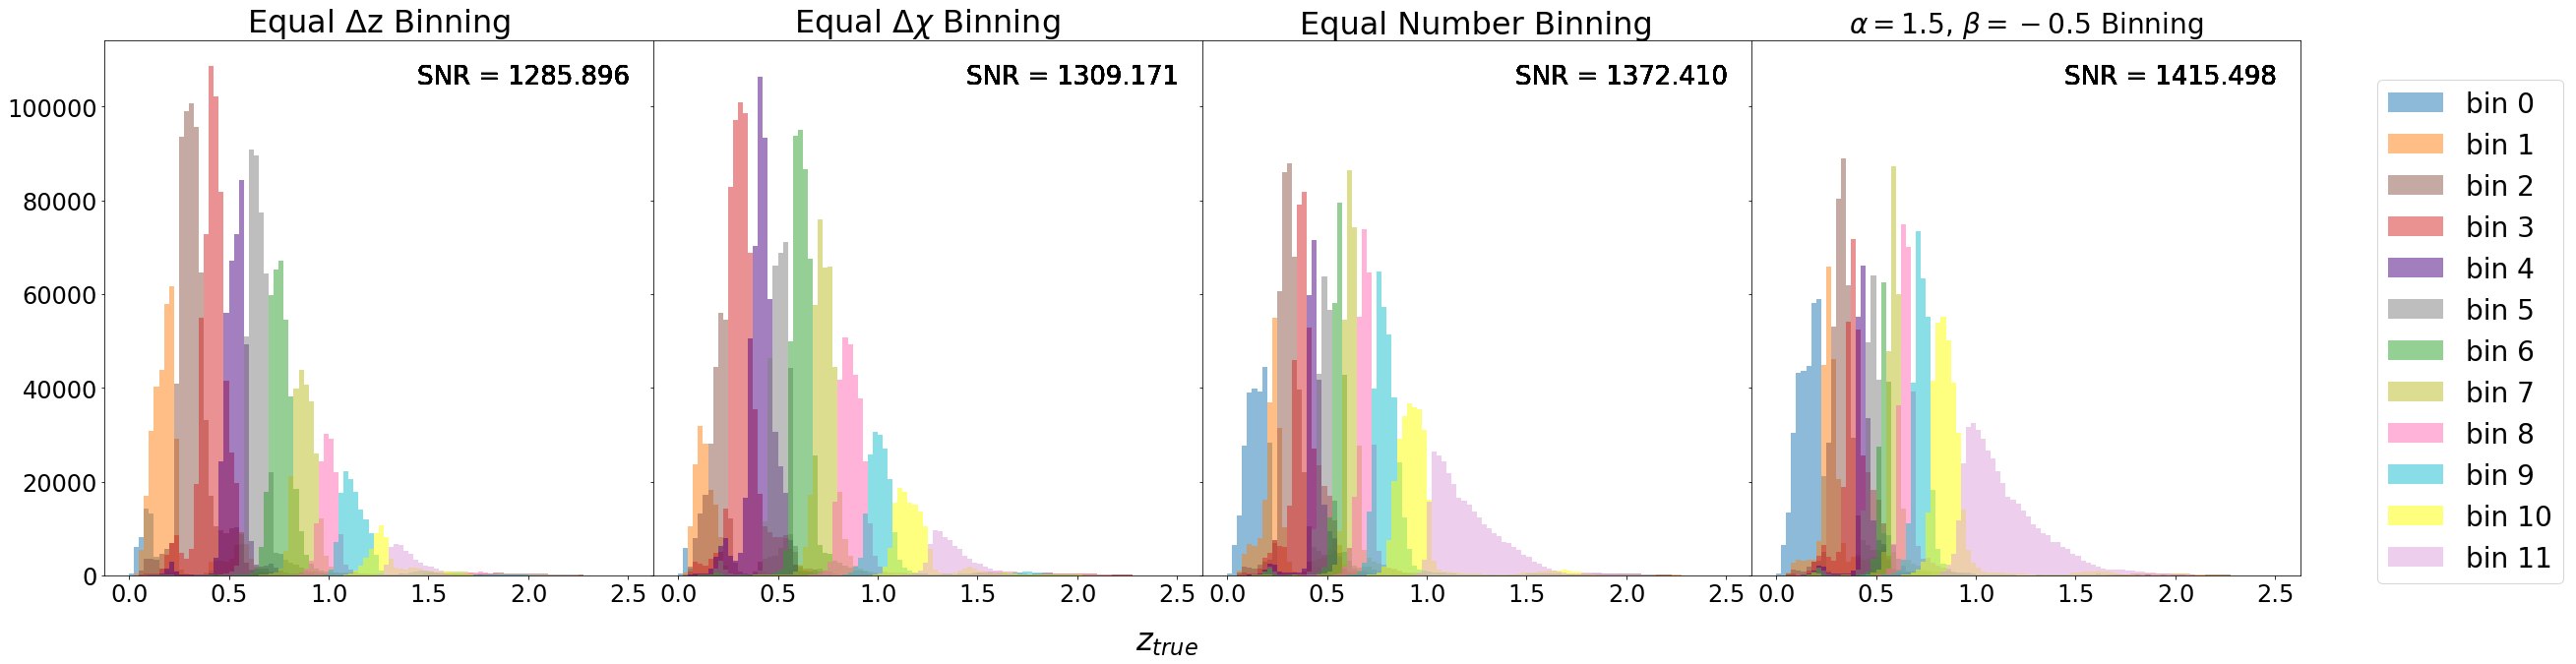

In [16]:
import matplotlib
from matplotlib.offsetbox import AnchoredText

matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=1
num_cols=4

text_z = AnchoredText('SNR = %.3f' % snr[0], prop=dict(size=26), frameon=False, loc='upper right')
text_chi = AnchoredText('SNR = %.3f' % snr[1], prop=dict(size=26), frameon=False, loc='upper right')
text_num = AnchoredText('SNR = %.3f' % snr[2], prop=dict(size=26), frameon=False, loc='upper right')
text_opt = AnchoredText('SNR = %.3f' % snr[3], prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

for i in range(num_cols):
    if i == 0:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Equal $\Delta$z Binning', fontsize=32)
            ax[i].add_artist(text_z)         
                        
            bin_to_plot = dict_of_dicts['alpha_0.0_beta_0.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5], label=f'bin {k}')
        ax[i].set_rasterized(True)
                
    if i == 1:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Equal $\Delta \chi$ Binning', fontsize=32)
            ax[i].add_artist(text_chi)
                        
            bin_to_plot = dict_of_dicts['alpha_0.0_beta_1.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)
        
    if i == 2:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Equal Number Binning', fontsize=32)
            ax[i].add_artist(text_num)
                        
            bin_to_plot = dict_of_dicts['alpha_1.0_beta_0.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)
        
    if i == 3:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'$\alpha=1.5$, $\beta=-0.5$ Binning', fontsize=28)
            ax[i].add_artist(text_opt)
                        
            bin_to_plot = dict_of_dicts[f'alpha_{alpha[i]}_beta_{beta[i]}'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=28)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=32)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

fig.savefig('paper_plots/alpha_beta_binning_comp_buzzard.pdf', bbox_inches='tight')
fig.show()

###### Step 2: Make Sample Selection Using NNCs

In [19]:
def filtering(data_features, retained_fraction):
    
    '''
    Filters the data frame to keep a given percentage of the data. If using an NNC trained to identify misclassified galaxies, this will produce 3 dataframes of features filtered by condfidence for each 
    binning type. Otherwise, this function returns a single dataframe filtered by NNC confidence.
    data_features: dataframe of features
    retained_fraction: how much of the original sample you want to keep. float between 0 and 1
    use_misclass: boolean
    '''


    #find the confidence threshold
    sorted_features = data_features.sort_values(by=['conf'], ignore_index=True)
    cut_value = int((1-retained_fraction)*len(sorted_features))
    conf_thresh = sorted_features['conf'][cut_value]
    
    #create filtered dataframe
    filtered_features = data_features[data_features['conf'] >= conf_thresh]
    
    return filtered_features, conf_thresh

In [9]:
del(dict_of_dicts)

NameError: name 'dict_of_dicts' is not defined

### Load data with misclassification NNC confidences

In [9]:
#already have features with outlier confidences
#Load misclassification features for both equal number and the optimal case
file_path_equal_num = f'{folder}/{data_set}/{misclass_equal_num_folder}'
file_path_optimal = f'{folder}/{data_set}/{misclass_optimal_folder}'
features_num = load_data(file_path_equal_num, num_of_bins=bin_num, use_size=True, use_misclass=True)
features_opt = load_data(file_path_optimal, num_of_bins=bin_num, use_size=True, use_misclass=True)

### Filter by confidence value

In [35]:
filtered_features_out, conf_thresh_out = filtering(features, retained_fraction=0.9)
filtered_features_num, conf_thresh_num = filtering(features_num, retained_fraction=0.85)
filtered_features_opt, conf_thresh_opt = filtering(features_opt, retained_fraction=0.85)

Extract redshift info

In [36]:
photz_out = filtered_features_out['zphot'].to_numpy()
specz_out = filtered_features_out['specz'].to_numpy()

photz_num = filtered_features_num['zphot'].to_numpy()
specz_num = filtered_features_num['specz'].to_numpy()

photz_opt = filtered_features_opt['zphot'].to_numpy()
specz_opt = filtered_features_opt['specz'].to_numpy()

### Make Confidence Cuts Plot

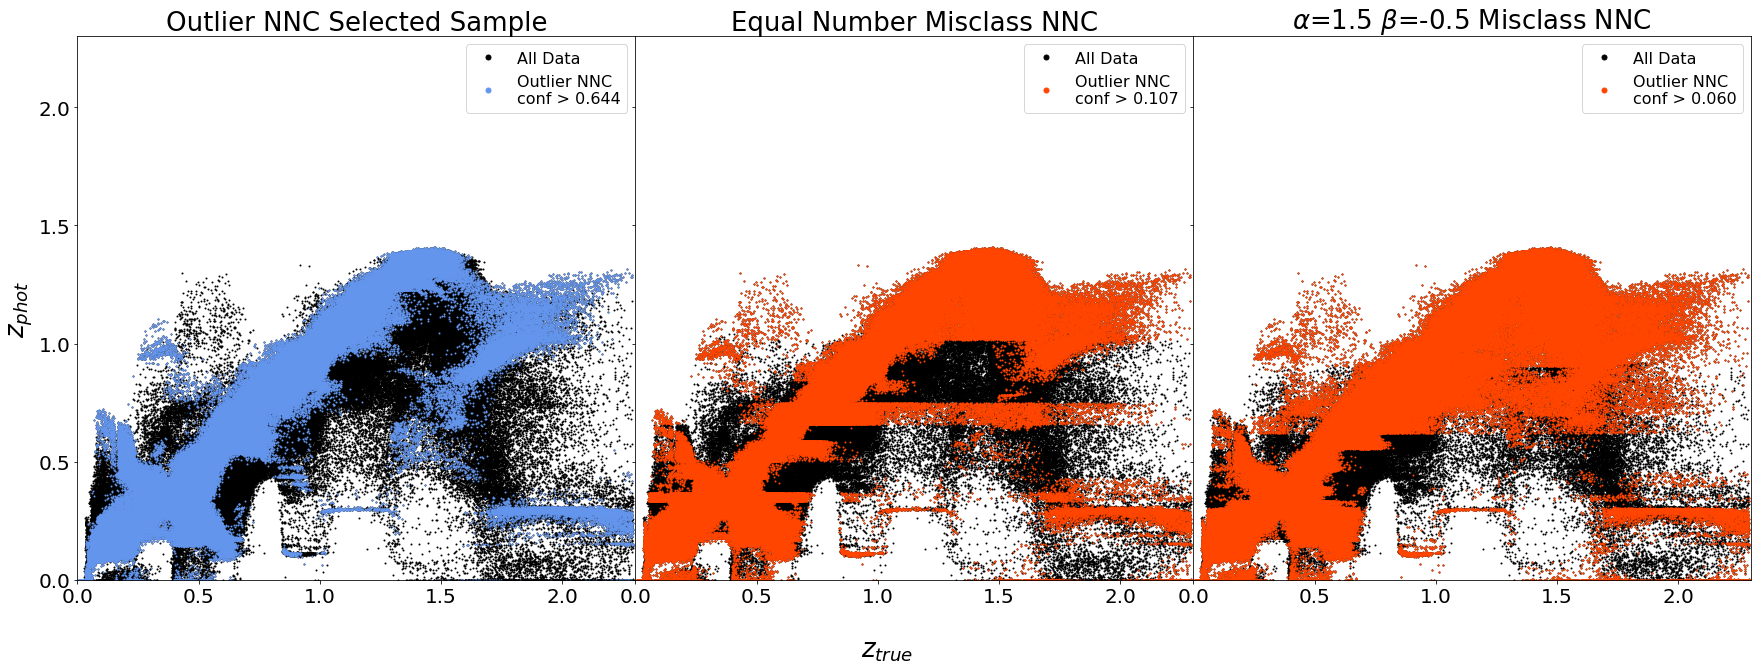

In [41]:
#z_max = 3.1
text_loc_y = 2.25
text_loc_x = 0.01
legend_loc = 8
retained_frac = 0.8
        
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

num_rows=1
num_cols=3
#x = np.linspace(0, z_max, 3)

text_out = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Outlier Cuts: %.0f' % len(photz_out), 'Retained Fraction: %.2f' %retained_frac))
text_num = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Misclass Cuts: %.0f' % len(photz_num), 'Retained Fraction: %.2f' %retained_frac))
text_opt = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Misclass Cuts: %.0f' % len(photz_opt), 'Retained Fraction: %.2f' %retained_frac))

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

for i in range(num_cols):
    ax[i].plot(z_spec, z_phot, '.k', markersize=2, label='All Data', rasterized=True)
    ax[i].set_xlim([0, 2.3])
    ax[i].set_ylim([0, 2.3])
    
    if i == 0:
        ax[i].plot(specz_out, photz_out, '.', color='cornflowerblue', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_out)), rasterized=True)
        #ax[i].text(text_loc_x, text_loc_y, text_out, fontsize=18, verticalalignment='top')
        ax[i].set_title('Outlier NNC Selected Sample', fontsize=26)
        ax[i].set_ylabel(r'$z_{phot}$', fontsize=26)
        ax[i].legend(markerscale=5, fontsize=16)
        
    if i == 1:
        ax[i].plot(specz_num, photz_num, '.', color='orangered', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_num)), rasterized=True)
        #ax[i].text(text_loc_x, text_loc_y, text_num, fontsize=18, verticalalignment='top')
        ax[i].set_title('Equal Number Misclass NNC', fontsize=26)
        ax[i].legend(markerscale=5, fontsize=16)
        
    if i == 2:
        ax[i].plot(specz_opt, photz_opt, '.', color='orangered', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_opt)), rasterized=True)
        #ax[i].text(text_loc_x, text_loc_y, text_opt, fontsize=18, verticalalignment='top')
        ax[i].set_title(r'$\alpha$=1.5 $\beta$=-0.5 Misclass NNC', fontsize=26)
        ax[i].legend(markerscale=5, fontsize=16)
#figure design
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=26)

#fig.suptitle('Selected Samples for {} with {} Bins'.format(title_string, bin_num), fontsize=title_font, y=0.92)
#fig.savefig(f'{file_string}/{title_string}_{bin_num}_bins_retaining_{keep_frac}_individual_bins.png', bbox_inches='tight')
fig.savefig('paper_plots/nnc_sample_selection_buzzard.pdf', bbox_inches='tight')

fig.show()

# Step 3: Bin Selected Samples

### Define Bin Edges and Sort

In [13]:
bin_edges_num = bin_edges('equal_num', bin_num, z_phot)
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=1.5, beta=-0.5, delta_z_step=delta_z, num_of_bins=bin_num)

results_out_num = do_binning(photz_out, bin_edges_num)
results_out_opt = do_binning(photz_out, bin_edges_opt)
results_mis_num = do_binning(photz_num, bin_edges_num)
results_mis_opt = do_binning(photz_opt, bin_edges_opt)

filtered_features_out['bins_num'] = results_out_num
filtered_features_out['bins_opt'] = results_out_opt
filtered_features_num['bins_num'] = results_mis_num
filtered_features_opt['bins_opt'] = results_mis_opt

/tmp/ipykernel_62377/1077657807.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out['bins_num'] = results_out_num
/tmp/ipykernel_62377/1077657807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out['bins_opt'] = results_out_opt
/tmp/ipykernel_62377/1077657807.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

### Calculate SNRs

In [14]:
scores_out_num = get_scores(results_out_num, specz_out, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_out_opt = get_scores(results_out_opt, specz_out, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_mis_num = get_scores(results_mis_num, specz_num, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_mis_opt = get_scores(results_mis_opt, specz_opt, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])

{'SNR_3x2': 1383.6553229828987}
{'SNR_3x2': 1428.9938327117695}
{'SNR_3x2': 1382.162735505064}
{'SNR_3x2': 1417.7944388507071}


In [15]:
bins_out_num = make_bins(filtered_features_out, bin_num, name_string='bins_num')
bins_out_opt = make_bins(filtered_features_out, bin_num, name_string='bins_opt')

bins_mis_num = make_bins(filtered_features_num, bin_num, name_string='bins_num')
bins_mis_opt = make_bins(filtered_features_opt, bin_num, name_string='bins_opt')

### Make Binning Plots

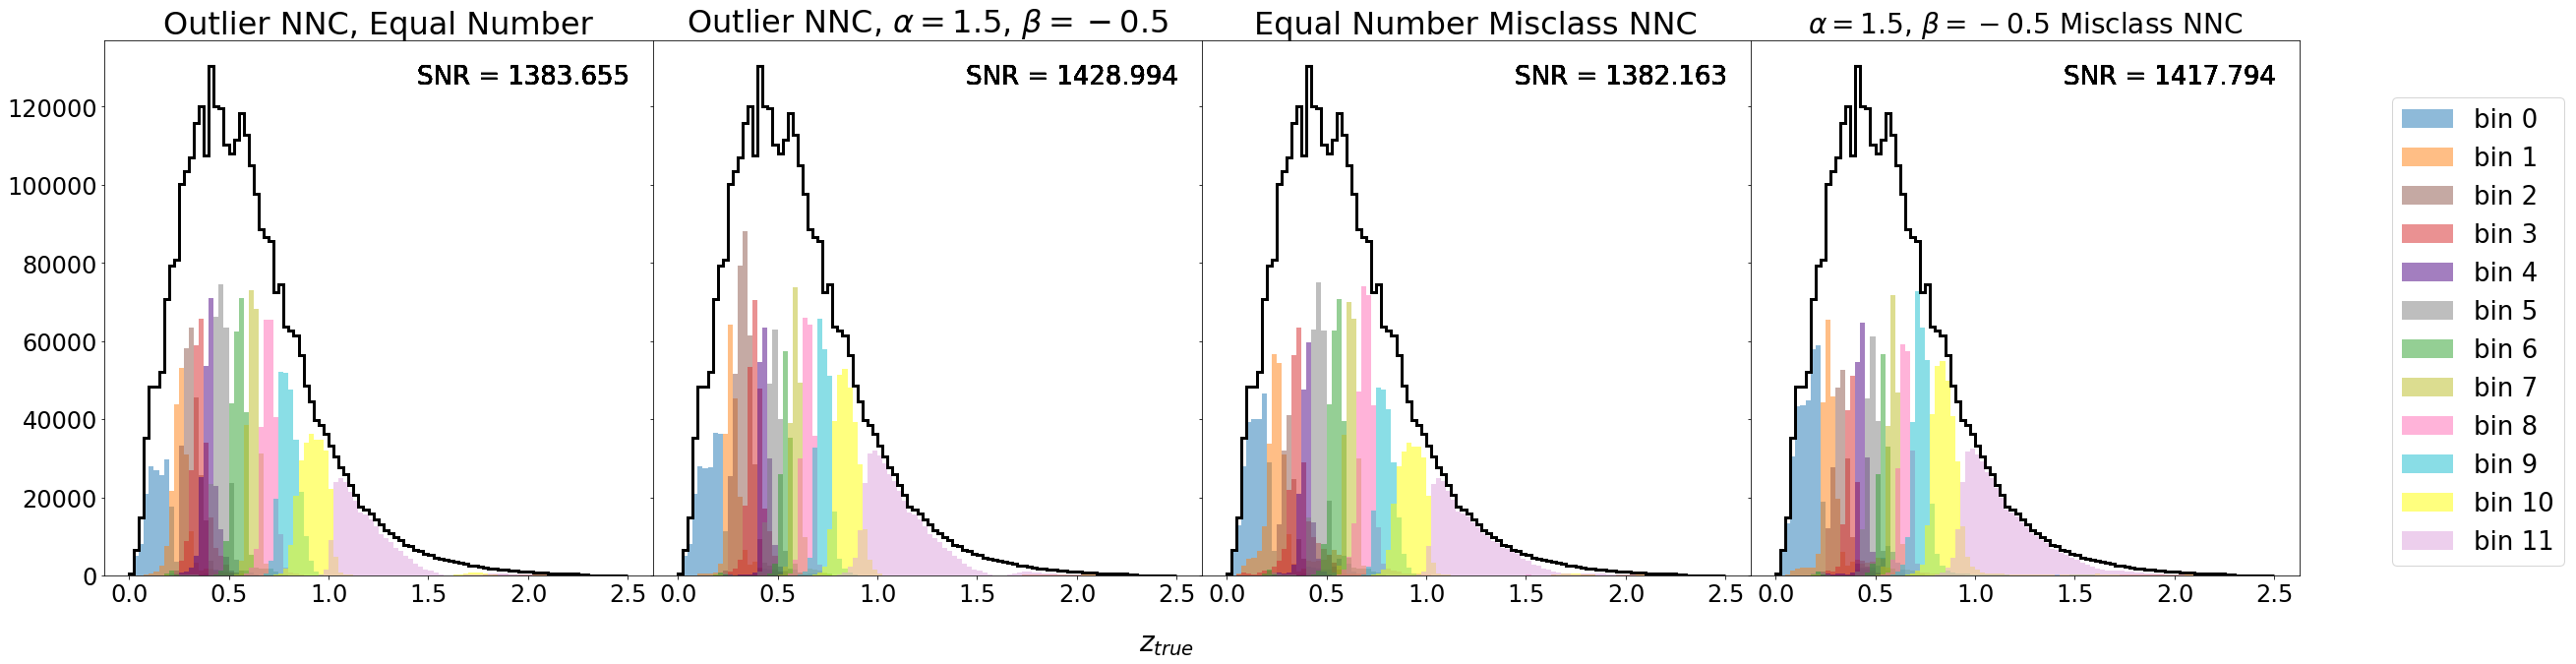

In [17]:
import matplotlib
from matplotlib.offsetbox import AnchoredText

matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=1
num_cols=4

text_out_num = AnchoredText('SNR = %.3f' % scores_out_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_out_opt = AnchoredText('SNR = %.3f' % scores_out_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_mis_num = AnchoredText('SNR = %.3f' % scores_mis_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_mis_opt = AnchoredText('SNR = %.3f' % scores_mis_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

N_of_z_overall = z_spec

for i in range(num_cols):
    ax[i].hist(z_spec, 100, histtype='step', range=[0,2.5], color='k', linewidth=3.0)
    if i == 0:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Outlier NNC, Equal Number', fontsize=32)
            ax[i].add_artist(text_out_num)         
                        
            bin_to_plot = bins_out_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5], label=f'bin {k}')
        ax[i].set_rasterized(True)
                
    if i == 1:
        for k in range(bin_num):
            bin_type = 'bins_opt'
            ax[i].set_title(r'Outlier NNC, $\alpha=1.5$, $\beta=-0.5$', fontsize=32)
            ax[i].add_artist(text_out_opt)
                        
            bin_to_plot = bins_out_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)
        
    if i == 2:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Equal Number Misclass NNC', fontsize=32)
            ax[i].add_artist(text_mis_num)
                        
            bin_to_plot = bins_mis_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)
        
    if i == 3:
        for k in range(bin_num):
            bin_type = 'bins_opt'
            ax[i].set_title(r'$\alpha=1.5$, $\beta=-0.5$ Misclass NNC', fontsize=28)
            ax[i].add_artist(text_mis_opt)
                        
            bin_to_plot = bins_mis_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,2.5])
        ax[i].set_rasterized(True)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=26)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=28)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

#fig.savefig('paper_plots/alpha_beta_binning_comp_cosmodc2.png', bbox_inches='tight')
fig.show()

# Step 4: Find Optimal Retained Fraction

In [12]:
retained_fracs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
snr_mis = []
snr_out = []
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=1.5, beta=-0.5, delta_z_step=delta_z, num_of_bins=bin_num)


for i in range(len(retained_fracs)):
    filtered_features, conf_thresh = filtering(features_opt, retained_fracs[i])
    photz = filtered_features['zphot'].to_numpy()
    specz = filtered_features['specz'].to_numpy()
    results = do_binning(photz, bin_edges_opt)
    filtered_features['bins_opt'] = results
    scores = get_scores(results, specz, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
    snr_mis.append(scores['SNR_3x2'])
    
    del(filtered_features)
    

/tmp/ipykernel_7342/2998805008.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features['bins_opt'] = results


{'SNR_3x2': 1372.9898557102997}
{'SNR_3x2': 1402.9047669266035}
{'SNR_3x2': 1417.7944388507071}
{'SNR_3x2': 1428.6613852384055}
{'SNR_3x2': 1410.0162060754699}
{'SNR_3x2': 1408.7652294315033}
{'SNR_3x2': 1415.497892969413}


In [13]:
snr_mis

[1372.9898557102997,
 1402.9047669266035,
 1417.7944388507071,
 1428.6613852384055,
 1410.0162060754699,
 1408.7652294315033,
 1415.497892969413]

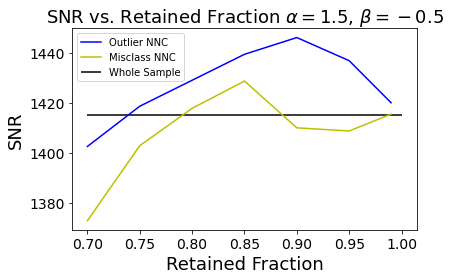

In [14]:
retained_fracs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
snr_mis = [1372.9898557102997, 1402.9047669266035, 1417.7944388507071, 1428.6613852384055, 1410.0162060754699, 1408.7652294315033, 1415.497892969413]
snr_out = [1402.58910281015, 1418.6379107070916, 1428.9938327117695, 1439.3460263936659, 1446.0284454661462, 1436.7952340129862, 1420.0339296086445]
snr_whole = 1415

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

plt.plot(retained_fracs, snr_out, 'b', label='Outlier NNC')
plt.plot(retained_fracs, snr_mis, 'y', label='Misclass NNC')
plt.hlines(snr_whole, xmin=0.7, xmax=1.0, colors='k', label='Whole Sample')

plt.legend()
plt.title(r'SNR vs. Retained Fraction $\alpha=1.5$, $\beta=-0.5$', fontsize=18)
plt.xlabel('Retained Fraction', fontsize=18)
plt.ylabel('SNR', fontsize=18)
plt.tight_layout()

#plt.savefig(f'paper_plots/SNR_vs_retained_frac_DC2.pdf', bbox_inches='tight')

plt.show()

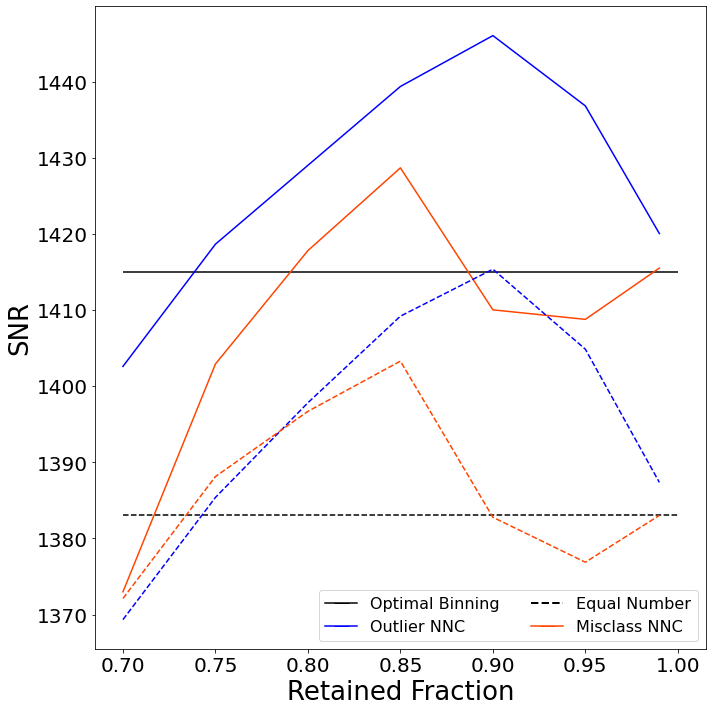

In [9]:
import matplotlib
import matplotlib.lines as mlines
retained_fracs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
snr_mis = [1372.9898557102997, 1402.9047669266035, 1417.7944388507071, 1428.6613852384055, 1410.0162060754699, 1408.7652294315033, 1415.497892969413]
snr_out = [1402.58910281015, 1418.6379107070916, 1428.9938327117695, 1439.3460263936659, 1446.0284454661462, 1436.7952340129862, 1420.0339296086445]
snr_whole = 1415

snr_whole_num = 1383.0258317912908
snr_out_num = [1369.3393359685049, 1385.381, 1397.8175597778709, 1409.1844005167347, 1415.352, 1404.8441502075023, 1387.3555532116009]
snr_mis_num = [1372.1099964344728, 1388.122, 1396.686504916534, 1403.2811177181602, 1382.776, 1376.8742102875144, 1383.0258317912908]

matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
title_font = 22
axis_font = 26
text_font = 16

plt.figure(figsize=(10,10))


plt.plot(retained_fracs, snr_out, 'b', label='Outlier NNC')
plt.plot(retained_fracs, snr_mis, 'orangered', label='Misclass NNC')
plt.hlines(snr_whole, xmin=0.7, xmax=1.0, colors='k', label='Whole Sample')

plt.plot(retained_fracs, snr_out_num, '--b', label='Outlier NNC')
plt.plot(retained_fracs, snr_mis_num, color='orangered', linestyle='dashed', label='Misclass NNC')
plt.hlines(snr_whole_num, xmin=0.7, xmax=1.0, colors='k', linestyle='dashed', label='Whole Sample')

black_line = mlines.Line2D([], [], color='k', marker='_', markersize=15, label='Outlier NNC')
dashed_line = mlines.Line2D([], [], color='k', linestyle='dashed', linewidth=2, label='Outlier NNC')
blue_line = mlines.Line2D([], [], color='b', marker='_', markersize=15, label='Outlier NNC')
red_line = mlines.Line2D([], [], color='orangered', marker='_', markersize=15, label='Misclass NNC')

plt.legend([black_line, blue_line, dashed_line, red_line], ['Optimal Binning', 'Outlier NNC', 'Equal Number', 'Misclass NNC'], ncol=2, fontsize=16)
#plt.title(r'SNR vs. Retained Fraction $\alpha=2.25$, $\beta=2.0$', fontsize=18)
plt.xlabel('Retained Fraction', fontsize=26)
plt.ylabel('SNR', fontsize=26)
plt.tight_layout()

plt.savefig(f'paper_plots/SNR_vs_retained_frac_buzzard.pdf', bbox_inches='tight')

plt.show()

# Step 5: Bin each sample with the optimal retained fraction.

In [17]:
file_path_equal_num = f'{folder}/{data_set}/{misclass_equal_num_folder}'
file_path_optimal = f'{folder}/{data_set}/{misclass_optimal_folder}'
features_num = load_data(file_path_equal_num, num_of_bins=bin_num, use_size=True, use_misclass=True)
features_opt = load_data(file_path_optimal, num_of_bins=bin_num, use_size=True, use_misclass=True)

In [20]:
filtered_features_out_num, conf_thresh_out_num = filtering(features, retained_fraction=0.9)
filtered_features_num, conf_thresh_num = filtering(features_num, retained_fraction=0.9)
filtered_features_out_opt, conf_thresh_out_opt = filtering(features, retained_fraction=0.85)
filtered_features_opt, conf_thresh_opt = filtering(features_opt, retained_fraction=0.85)

In [21]:
photz_out_num = filtered_features_out_num['zphot'].to_numpy()
specz_out_num = filtered_features_out_num['specz'].to_numpy()

photz_num = filtered_features_num['zphot'].to_numpy()
specz_num = filtered_features_num['specz'].to_numpy()

photz_out_opt = filtered_features_out_opt['zphot'].to_numpy()
specz_out_opt = filtered_features_out_opt['specz'].to_numpy()

photz_opt = filtered_features_opt['zphot'].to_numpy()
specz_opt = filtered_features_opt['specz'].to_numpy()

In [29]:
bin_edges_num = bin_edges('equal_num', bin_num, z_phot)
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=1.5, beta=-0.5, delta_z_step=delta_z, num_of_bins=bin_num)

results_out_num = do_binning(photz_out_num, bin_edges_num)
results_out_opt = do_binning(photz_out_opt, bin_edges_opt)
results_mis_num = do_binning(photz_num, bin_edges_num)
results_mis_opt = do_binning(photz_opt, bin_edges_opt)

filtered_features_out_num['bins_num'] = results_out_num
filtered_features_out_opt['bins_opt'] = results_out_opt
filtered_features_num['bins_num'] = results_mis_num
filtered_features_opt['bins_opt'] = results_mis_opt

/tmp/ipykernel_54687/619855589.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out_num['bins_num'] = results_out_num
/tmp/ipykernel_54687/619855589.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out_opt['bins_opt'] = results_out_opt
/tmp/ipykernel_54687/619855589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [30]:
results_num = do_binning(z_phot, bin_edges_num)
results_opt = do_binning(z_phot, bin_edges_opt)
                         
features['bins_num'] = results_num
features['bins_opt'] = results_opt

In [31]:
#Equal number binning scores
scores_num = {'SNR_3x2': 1372.410}
scores_out_num = {'SNR_3x2': 1415.352}
scores_mis_num = {'SNR_3x2': 1403.2811177181602}

#Optimal Binning Scores
scores_opt = {'SNR_3x2': 1415.498}
scores_out_opt = {'SNR_3x2': 1446.0284454661462}
scores_mis_opt = {'SNR_3x2': 1428.6613852384055}

In [32]:
bins_out_num = make_bins(filtered_features_out_num, bin_num, name_string='bins_num')
bins_out_opt = make_bins(filtered_features_out_opt, bin_num, name_string='bins_opt')

bins_mis_num = make_bins(filtered_features_num, bin_num, name_string='bins_num')
bins_mis_opt = make_bins(filtered_features_opt, bin_num, name_string='bins_opt')

bins_num = make_bins(features, bin_num, name_string='bins_num')
bins_opt = make_bins(features, bin_num, name_string='bins_opt')

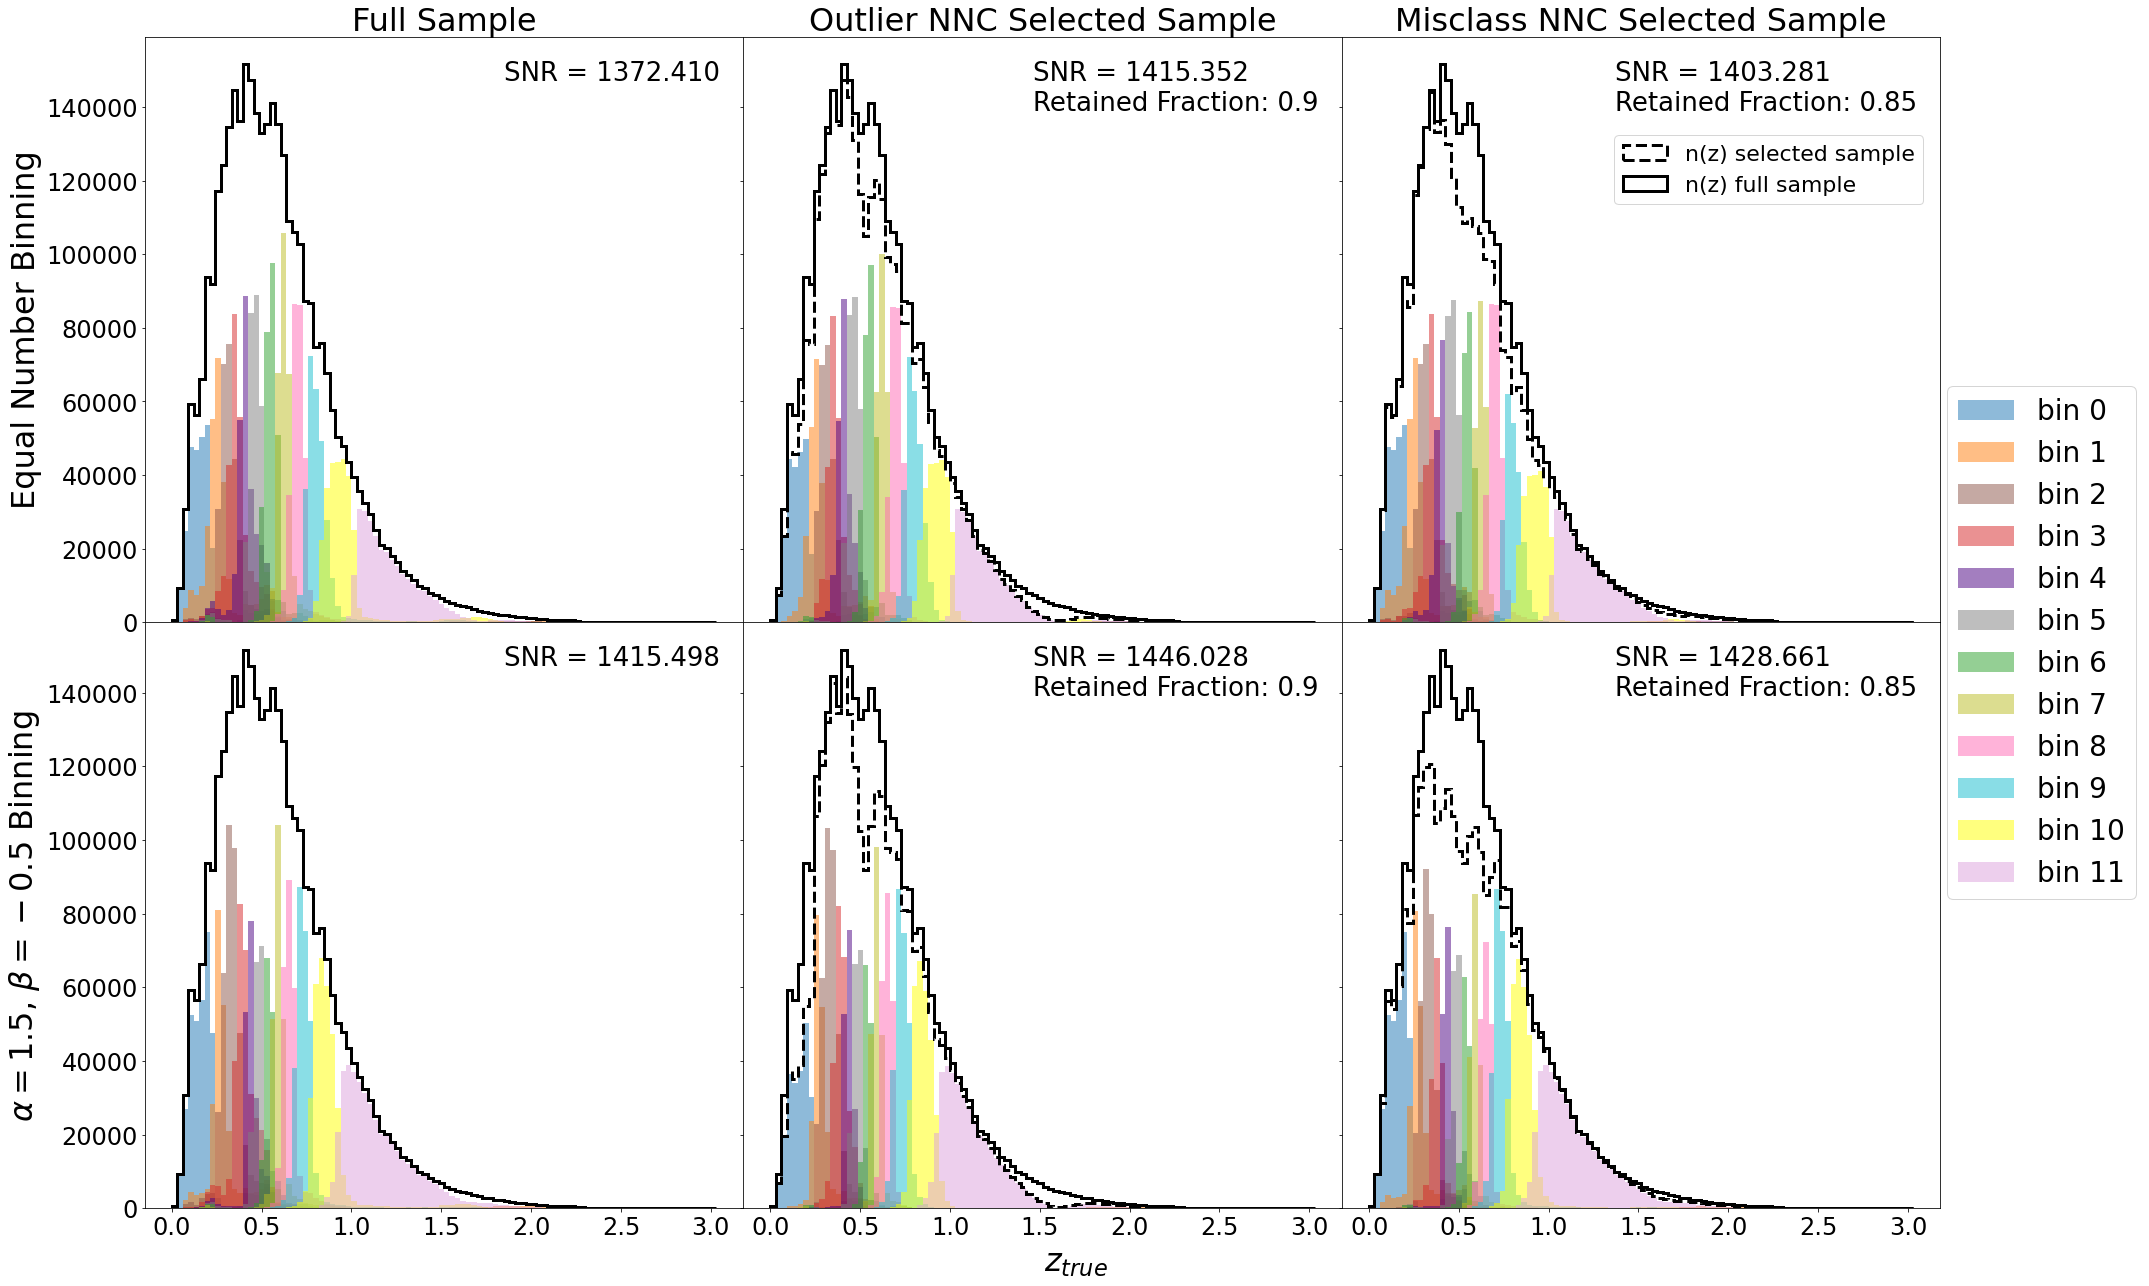

In [34]:
from matplotlib.offsetbox import AnchoredText
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=2
num_cols=3

text_num = AnchoredText('SNR = %.3f' % scores_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_opt = AnchoredText('SNR = %.3f' % scores_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_out_num = AnchoredText('\n'.join(('SNR = %.3f' % scores_out_num['SNR_3x2'], 'Retained Fraction: 0.9')), prop=dict(size=26), frameon=False, loc='upper right')
text_out_opt = AnchoredText('\n'.join(('SNR = %.3f' % scores_out_opt['SNR_3x2'], 'Retained Fraction: 0.9')), prop=dict(size=26), frameon=False, loc='upper right')
text_mis_num = AnchoredText('\n'.join(('SNR = %.3f' % scores_mis_num['SNR_3x2'], 'Retained Fraction: 0.85')), prop=dict(size=26), frameon=False, loc='upper right')
text_mis_opt = AnchoredText('\n'.join(('SNR = %.3f' % scores_mis_opt['SNR_3x2'], 'Retained Fraction: 0.85')), prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*9))

N_of_z_overall = z_spec


#top row is equal number binning
for i in range(num_cols):    
    if i == 0:
        ax[0,i].set_title(r'Full Sample', fontsize=32)
        ax[0,i].set_ylabel(r'Equal Number Binning', fontsize=32)
        ax[0,i].add_artist(text_num) 
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
    
    if i == 1:
        ax[0,i].set_title(r'Outlier NNC Selected Sample', fontsize=32)
        ax[0,i].add_artist(text_out_num)
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_out_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[0,i].hist(specz_out_num, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0)#, label=r'n(z) selected sample')
        #ax[0,i].legend()
        
    if i == 2:
        ax[0,i].set_title(r'Misclass NNC Selected Sample', fontsize=32)
        ax[0,i].add_artist(text_mis_num)
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_mis_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])#, label=f'bin {k}')
        ax[0,i].hist(specz_num, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')
        ax[0,i].hist(z_spec, 100, histtype='step', range=[0,3.03], color='k', linewidth=3.0, label=r'n(z) full sample')
        ax[0,i].legend(fontsize=22, loc='upper right', bbox_to_anchor=(0.99, 0.85))
            
#bottom row is optimal binning
for i in range(num_cols):   
    if i == 0:
        ax[1,i].set_ylabel(r'$\alpha=1.5$, $\beta=-0.5$ Binning', fontsize=32)
        ax[1,i].add_artist(text_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
    
    if i == 1:
        ax[1,i].add_artist(text_out_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_out_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[1,i].hist(specz_out_opt, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')
        
    if i == 2:
        ax[1,i].add_artist(text_mis_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_mis_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[1,i].hist(specz_opt, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')

for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].set_rasterized(True)
        ax[i,j].spines
        ax[i,j].hist(z_spec, 100, histtype='step', range=[0,3.03], color='k', linewidth=3.0)#, label=r'n(z) full sample')
    

fig.supxlabel(r'$z_{true}$', fontsize=32)
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.subplots_adjust(right=0.9)
handles, labels = ax[0,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=28)
  
fig.savefig('paper_plots/best_binning_buzzard.pdf', bbox_inches='tight')    
fig.show()